In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%load_ext autotime

### 0. Loading training data

In [ ]:
df = pd.read_parquet('../data/processed/train_features.parquet')
df.shape

In [3]:
y, x = df.pop('country_destination'), df
x.drop('user_id', axis=1, inplace=True)

time: 13.9 s (started: 2021-08-17 12:59:43 +00:00)


### 1. Splitting tain data into stratified train, validation and test sets

In [4]:
cat_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dow_registered',
    'hr_registered',
    'age_group',
    'dow_registered',
    'day_registered',
    'month_registered',
    'year_registered',
]

time: 1.59 ms (started: 2021-08-17 13:00:36 +00:00)


In [9]:
x.gender.dtype

CategoricalDtype(categories=['-unknown-', 'FEMALE', 'MALE', 'OTHER'], ordered=False)

time: 14.6 ms (started: 2021-08-17 13:02:46 +00:00)


In [7]:
# for col in cat_features:
#     try:
#         if col not in list(x):
#             print(col)
#             continue
# #         x[col].fillna('', inplace=True)
# #         x[col] = x[col].astype('category')
#         print(x[col].dtype)
#     except Exception as e:
#         print(col)
#         print(e)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    train_size=0.9, 
    random_state=42,
    stratify=y
)
x_train.shape, x_test.shape

((192105, 957), (21346, 957))

time: 3.25 s (started: 2021-08-17 13:03:20 +00:00)


In [12]:
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, 
    y_train, 
    train_size=0.8,
    random_state=42,
    stratify=y_train
)
x_train.shape, x_validation.shape

((153684, 957), (38421, 957))

time: 7.07 s (started: 2021-08-17 13:03:23 +00:00)


### 1.1 Checking that the ratios of the target class are invariant

In [8]:
# y_train.value_counts() / len(y_train)

time: 679 µs (started: 2021-08-17 11:51:48 +00:00)


In [9]:
# y_validation.value_counts() / len(y_validation)

time: 7.07 ms (started: 2021-08-17 11:51:48 +00:00)


### 2. Model Training

In [13]:
classes = np.unique(y_train)
classes

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

time: 213 ms (started: 2021-08-17 13:03:30 +00:00)


In [14]:
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights

array([33.00773196, 12.45817121, 16.76308901,  7.91043854,  3.54077965,
        7.65053763,  6.27486526,  0.14282369, 23.32786885, 82.09615385,
        0.28517034,  1.76210787])

time: 106 ms (started: 2021-08-17 13:03:30 +00:00)


In [15]:
class_weights = dict(zip(classes, weights))

time: 663 µs (started: 2021-08-17 13:03:30 +00:00)


In [16]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy'],
    loss_function='MultiClass',
    class_weights=class_weights,
#     depth=10,
#     eval_metric
)

time: 2.14 ms (started: 2021-08-17 13:03:46 +00:00)


In [ ]:
model.fit(
    x_train, y_train,
    cat_features=cat_features,
    eval_set=(x_validation, y_validation),
    early_stopping_rounds=5,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 3. Testing model on test sets

In [15]:
y_pred = model.predict(x_test)

time: 562 ms (started: 2021-08-17 12:02:06 +00:00)


In [16]:
labels = y_validation.value_counts().index.tolist()
labels

['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']

time: 54.3 ms (started: 2021-08-17 12:02:07 +00:00)


In [17]:
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='all')

time: 90.1 ms (started: 2021-08-17 12:02:08 +00:00)


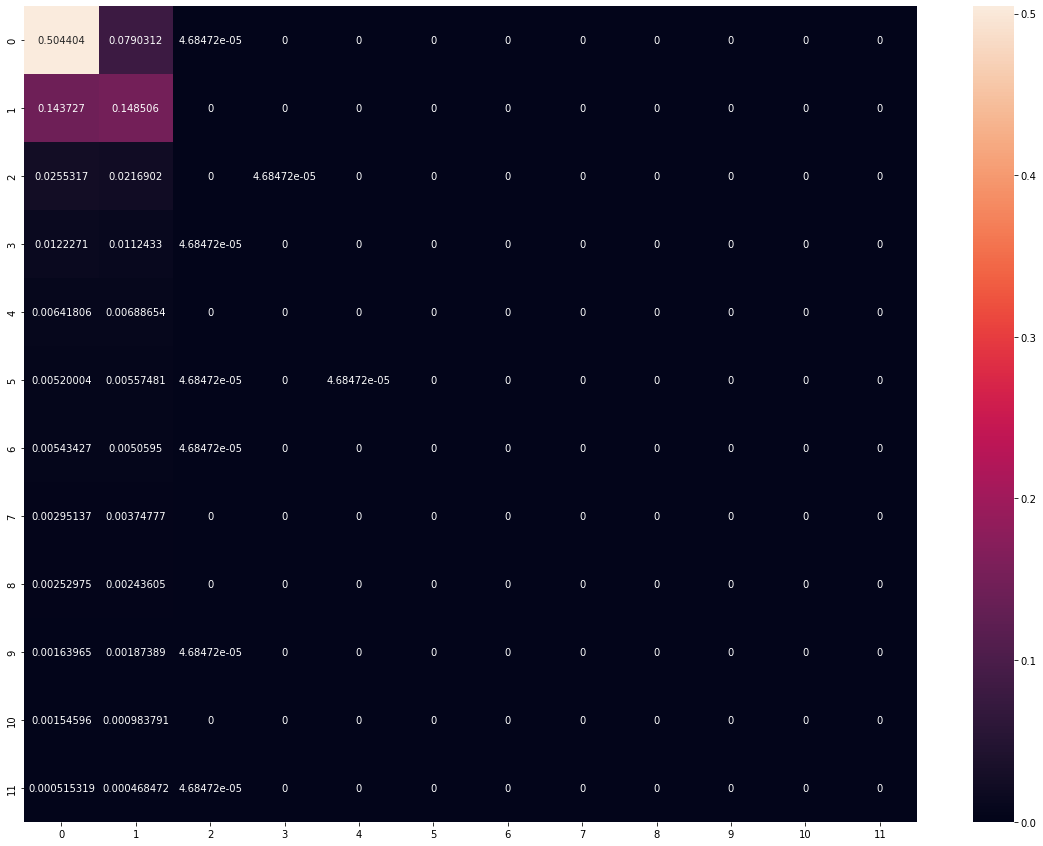

time: 1.55 s (started: 2021-08-17 12:02:14 +00:00)


In [18]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

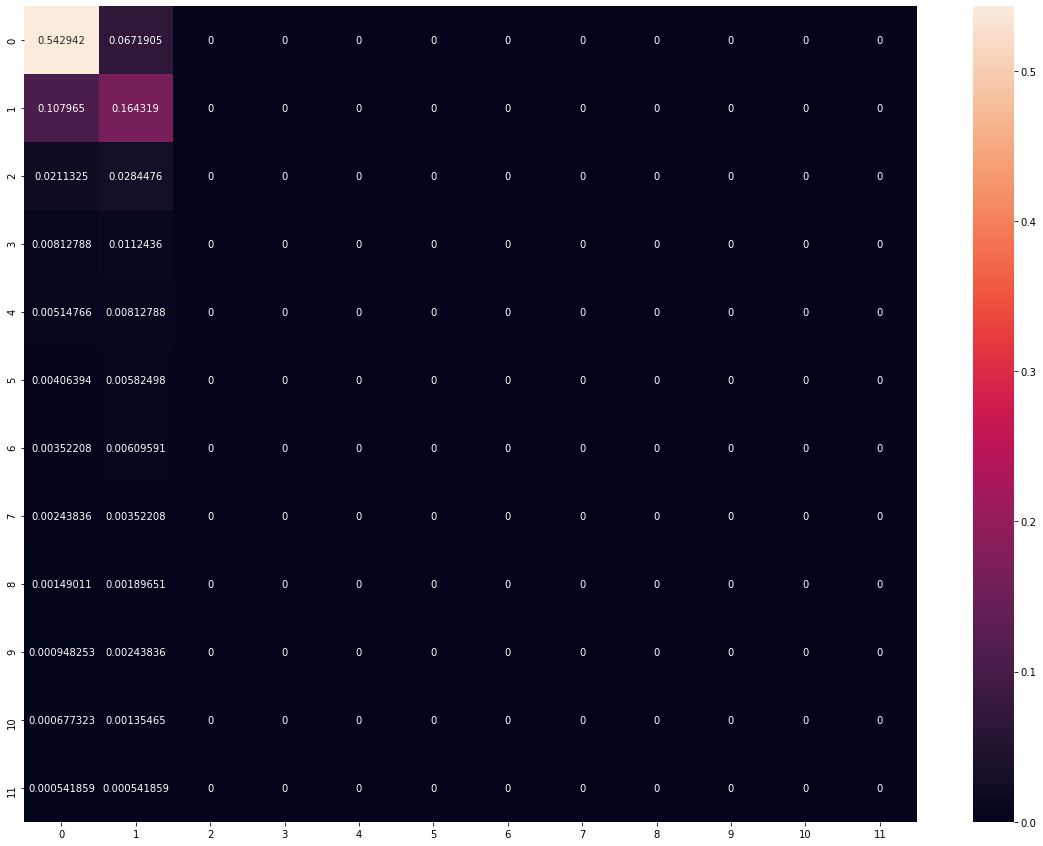

time: 896 ms (started: 2021-08-16 12:42:38 +00:00)


In [19]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

### 5. Saving Model

In [19]:
model.save_model('../models/model2.cbm')

time: 39.4 ms (started: 2021-08-17 12:03:05 +00:00)
